Install dependencies:

In [ ]:
#!pip install seaborn
#!pip install librosa
#!pip install scikit-image
#!pip install datasets

In [ ]:
#!pip install kaggle

Import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os as os
import tensorflow as tf

from joblib import delayed, Parallel
from tqdm import tqdm

import librosa
import librosa.display
import IPython.display as ipd
import skimage.io

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [ ]:
# We can also set up our kaggle API key in secrets and download the data straight from the challenge URL into our temp colab directory

Mount drive so that we have access to the data uploaded there, saved models, etc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make directory for the unzipped data in current run time, allowing quicker access to the data during preprocesing.

In [3]:
!mkdir /content/unzip_data

##### Unzip the data into the directory: I initially downloaded the zip file from the Kaggle challenge and uploaded it to Google Drive in my notebooks folder.

In [5]:
!unzip '/content/drive/MyDrive/Colab Notebooks/kaggle-pog-series-s01e02.zip' -d /content/unzip_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/unzip_data/train/018723.ogg  
  inflating: /content/unzip_data/train/018724.ogg  
  inflating: /content/unzip_data/train/018725.ogg  
  inflating: /content/unzip_data/train/018726.ogg  
  inflating: /content/unzip_data/train/018727.ogg  
  inflating: /content/unzip_data/train/018728.ogg  
  inflating: /content/unzip_data/train/018729.ogg  
  inflating: /content/unzip_data/train/018731.ogg  
  inflating: /content/unzip_data/train/018733.ogg  
  inflating: /content/unzip_data/train/018734.ogg  
  inflating: /content/unzip_data/train/018735.ogg  
  inflating: /content/unzip_data/train/018737.ogg  
  inflating: /content/unzip_data/train/018738.ogg  
  inflating: /content/unzip_data/train/018740.ogg  
  inflating: /content/unzip_data/train/018741.ogg  
  inflating: /content/unzip_data/train/018742.ogg  
  inflating: /content/unzip_data/train/018743.ogg  
  inflating: /content/unzip_data/train/018744.ogg  
  inflating: 

##### Alternativley, you can run the following few lines of code to download the dataset directly from kaggle and then unzip it.

You need to create a kaggle account and then generate a Kaggle API token which will be downloaded as a .json file to your machine.

 Run the follow code to select and upload the recently downloaded kaggle.json API token to the colab runtime:

In [71]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jamiepeake","key":"a83dc07bf7d46d815d4650fc736c083a"}'}

Remove any possible existing kaggle directory before created a new one, then move the kaggle.json API key in here, and change the permissions with chmod 600:

In [78]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Finally, download the dataset from the competition URL as follows... in my case the following code I found here : https://www.kaggle.com/competitions/kaggle-pog-series-s01e02/data

In [77]:
!kaggle competitions download -c kaggle-pog-series-s01e02

100% 9.04G/9.05G [02:29<00:00, 92.2MB/s]
100% 9.05G/9.05G [02:29<00:00, 65.0MB/s]


Now unzip this data into the unzip_data directory:

In [ ]:
!unzip /content/kaggle-pog-series-s01e02.zip -d /content/unzip_data

##### Loading the audio data and metadata

In [42]:
# Defining path variables

class DataPath:
    def __init__(self, data, audio_path, process, processed_train, processed_test, unzip):
        self.data = data
        self.audio = audio_path
        self.process = process
        self.protrain = processed_train
        self.protest =  processed_test
        self.unzip = unzip



DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/"
UNZIPPED_DATA = "/content/unzip_data/"
AUDIO_PATH = UNZIPPED_DATA + "train/"
PROCESSED_TRAIN_DATA = UNZIPPED_DATA + "processed_train/"
PROCESSED_TEST_DATA = UNZIPPED_DATA + "processed_test/"

PATH = DataPath(DATA_PATH, AUDIO_PATH, 'data/processed/', PROCESSED_TRAIN_DATA, PROCESSED_TEST_DATA, UNZIPPED_DATA)


Load metadata into pandas dataframes

In [51]:
df_known = pd.read_csv(PATH.unzip + 'train.csv')
#df_test = pd.read_csv('data/kaggle-pog-series-s01e02/test.csv')
#submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/kaggle-pog-series-s01e02/sample_submission.csv')
df_known

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock
...,...,...,...,...,...
19917,9337,009337.ogg,train/009337.ogg,0,Electronic
19918,8340,008340.ogg,train/008340.ogg,4,Hip-Hop
19919,16248,016248.ogg,train/016248.ogg,4,Hip-Hop
19920,11875,011875.ogg,train/011875.ogg,2,Punk


Remove rows from dataframe that don't exist as an audio file

In [9]:
df_known = df_known[[os.path.isfile(PATH.data + i) for i in df_known['filepath']]]
#df_test = df_test[[os.path.isfile('data/kaggle-pog-series-s01e02/'+i) for i in df_test['filepath']]]

df_known

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock
...,...,...,...,...,...
19917,9337,009337.ogg,train/009337.ogg,0,Electronic
19918,8340,008340.ogg,train/008340.ogg,4,Hip-Hop
19919,16248,016248.ogg,train/016248.ogg,4,Hip-Hop
19920,11875,011875.ogg,train/011875.ogg,2,Punk


Define function that loads audio .ogg files with librosa, converts to mono and resamples to 16k (human hearing)

In [39]:
def load_ogg_16k_mono(filename):
    # Load encoded ogg file
    y, sr = librosa.load(filename)
    #convert all files to mono (if not already)
    y = librosa.to_mono(y)
    # Goes to 16000hz - reduced sample rate within human hearing
    y = librosa.resample(y, orig_sr=sr, target_sr=16000)
    return y

Find the max and min lengths across all the audio files (takes a while to run)

In [50]:
lengths = []
for file in tqdm(os.listdir(os.path.join(PATH.unzip, 'train'))):
    ogg_file = load_ogg_16k_mono(os.path.join(PATH.unzip, 'train', file))
    lengths.append(len(ogg_file))

  6%|▋         | 1285/19909 [02:58<43:11,  7.19it/s]


KeyboardInterrupt: 

In [ ]:
print(lengths)

In [ ]:
min(lengths)/16000, max(lengths)/16000

Create directories to store processed data

In [16]:
def create_processing_dirs():
    if not os.path.isdir(PATH.protrain):
        os.mkdir(PATH.protrain)
    if not os.path.isdir(PATH.protest):
        os.mkdir(PATH.protest)

Define preprocessing functions:

In [44]:
#creates and then saves mel spectogram as .npy file
def preprocess1(file_name, dest = None):
    ogg = load_ogg_16k_mono(file_name)
    ogg = ogg[:480000]
    zero_padding = np.zeros((480000) - np.shape(ogg)[0], dtype=np.float32)
    ogg = np.concatenate((zero_padding, ogg),0)
    S = librosa.feature.melspectrogram(y=ogg,sr=16000,n_mels=128 * 2,)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    melnorm = librosa.util.normalize(S_db_mel)
    file_name = file_name.split('.')[0]
    file_name = file_name.split('/')[-1]
    np.save(PATH.protrain + 'mels/' + file_name + '.npy', melnorm)
    return

In [41]:
#creates and returns mel spectogram
def preprocess2(file_name, dest = None):
    ogg = load_ogg_16k_mono(file_name)
    ogg = ogg[:480000]
    zero_padding = np.zeros((480000) - np.shape(ogg)[0], dtype=np.float32)
    ogg = np.concatenate((zero_padding, ogg),0)
    S = librosa.feature.melspectrogram(y=ogg,sr=16000,n_mels=128 * 2,)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    melnorm = librosa.util.normalize(S_db_mel)
    return melnorm

##### Data visualisation : Visualising some sample data as raw waveform and Mel-spectograms:

In [26]:
sample_audio = load_ogg_16k_mono('/content/unzip_data/'+next(iter(df_known.filepath.values)))

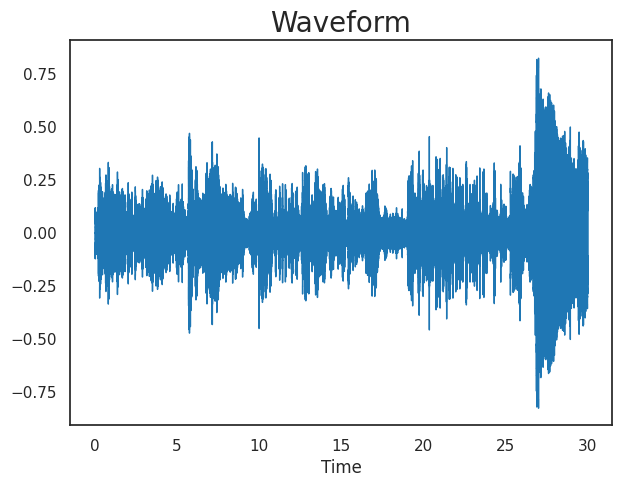

In [52]:
fig, ax = plt.subplots(figsize=(7, 5))
# Plot the waveform
img = librosa.display.waveshow(sample_audio,
                              sr = 16000,
                              ax=ax)
ax.set_title('Waveform', fontsize=20)
plt.show()

In [30]:
S_db_mel = preprocess2('/content/unzip_data/'+next(iter(df_known.filepath.values)))
S_db_mel

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -0.92485684, -0.83453906],
       [-1.        , -1.        , -0.8751675 , ..., -1.        ,
        -0.77272   , -0.6907017 ],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]], dtype=float32)

In [ ]:
np.shape(S_db_mel)

Visualise Mel-spectogram of a given file

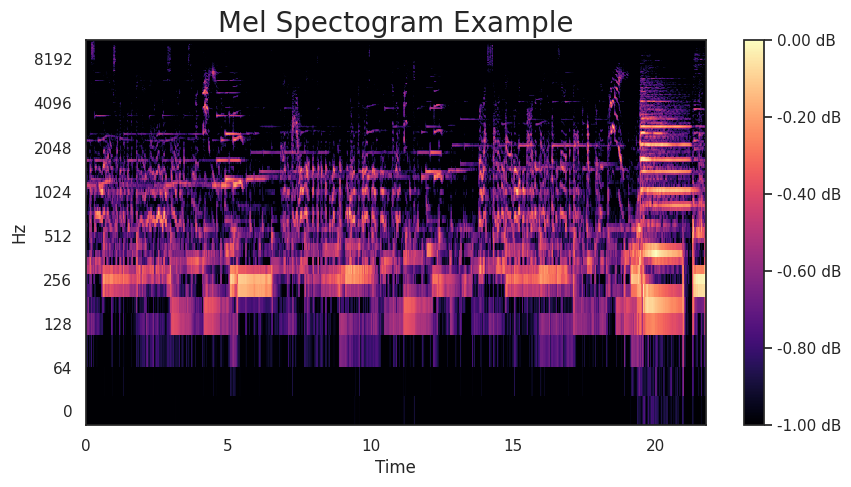

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f dB')
plt.show()

##### Preprocessing:

In [17]:
create_processing_dirs()

Directory to store mel spectograms as .npy files:

In [19]:
!mkdir /content/unzip_data/processed_train/mels/

In [ ]:
#delayed_preprocess = [delayed(preprocess2)(PATH.audio+path) for path in df_known.filename.values]
#df_known.loc[:,'melspec'] = Parallel(n_jobs=-1, verbose=5)(delayed_preprocess)

Preprocess the audio files and store them in the temp colab directory

In [45]:
delayed_preprocess = [delayed(preprocess1)(PATH.audio+path) for path in df_known.filename.values]
_ = Parallel(n_jobs=-1, verbose=5)(delayed_preprocess)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2174 tasks   

Zip the preprocessed files for ease of transfer later on

In [46]:
# !zip [ZIP FILE NAME . zip] [Location of Folder to ZIP]
!zip -r /content/unzip_data/processed_train/mels.zip  /content/unzip_data/processed_train/mels/

Streaming output truncated to the last 5000 lines.
  adding: content/unzip_data/processed_train/mels/020618.npy (deflated 71%)
  adding: content/unzip_data/processed_train/mels/015291.npy (deflated 91%)
  adding: content/unzip_data/processed_train/mels/009547.npy (deflated 84%)
  adding: content/unzip_data/processed_train/mels/017054.npy (deflated 82%)
  adding: content/unzip_data/processed_train/mels/020536.npy (deflated 80%)
  adding: content/unzip_data/processed_train/mels/021121.npy (deflated 65%)
  adding: content/unzip_data/processed_train/mels/021032.npy (deflated 74%)
  adding: content/unzip_data/processed_train/mels/021063.npy (deflated 62%)
  adding: content/unzip_data/processed_train/mels/024641.npy (deflated 53%)
  adding: content/unzip_data/processed_train/mels/006306.npy (deflated 65%)
  adding: content/unzip_data/processed_train/mels/014234.npy (deflated 56%)
  adding: content/unzip_data/processed_train/mels/004630.npy (deflated 57%)
  adding: content/unzip_data/processe

Copy the meta data .csv files back to drive to avoid having to unzip the original data set again during training

In [47]:
!cp /content/unzip_data/*.csv '/content/drive/MyDrive/Colab Notebooks/data'

Copy the zipped preprocessed data files back to the drive so we can unzip them later for training:

In [49]:
!cp /content/unzip_data/processed_train/mels.zip '/content/drive/MyDrive/Colab Notebooks/data/processed_train'